# AI for Earth System Science Hackathon 2020
# Microphysics Machine Learning Challenge Problem

David John Gagne, Gabrielle Gantos, Andrew Gettelman, Jack Chen

## Introduction
Cloud processes are perhaps the most critical and uncertain processes for weather and climate prediction. The complex nature of sub grid scale clouds makes traceable simulation of clouds across scales difficult (or impossible). There exist many observations and detailed simulations of clouds that are used to develop and evaluate larger scale models. Many times these models and measurements are used to develop empirical relationships for large scale models to be computationally efficient. Machine learning provides another potential tool to improve our empirical parameterizations of clouds. Here we present a comprehensive investigation of replacing the warm rain formation process in an earth system model with emulators that use detailed treatments from small scale and idealized models to represent key cloud microphysical processes. 

The warm rain formation process is critical for weather and climate prediction. When rain forms governs the location, intensity and duration of rainfall events, critical for weather and the hydrologic cycle. Rain formation also affects cloud lifetime and the radiative properties of low clouds, making it critical for predicting climate (Twomey et al. 1977, Albrecht et al. 1989) The specific process of rain formation is altered by the microphysical properties of clouds, making rain formation susceptible to the size distribution of cloud drops, and ultimately to the distribution of aerosol particles that act as Cloud Condensation Nuclei. 

Ice of course will complicate the precipitation process. Supercooled liquid drops can exist, and these will either precipitation in a similar manner to warm precipitation (with no ice involved) and subsequently may freeze once they are rain drops. Or cloud droplets may freeze and form ice crystals, which precipitate and collect liquid, freezing or riming as they fall. We will not concern ourselves in this work with processes involving (or potentially involving) ice. This of course is a critical issue for weather (Forbes et al. 2014)and climate (Gettelman et al. 2019b, Bodas-Salcedo et al. 2019)prediction. 

The representation of rain formation in clouds involves the interaction of a population of hydrometeors. For warm clouds, the process is one of collision and coalescence, usually defined with a detailed process of stochastic collection (Pruppacher et al. 1997). The stochastic collection process describes how each size particle interacts with other sizes. Usually there is a distribution of small cloud drops with an extension or separate distribution of rain drops whose interactions are evaluated. 

The stochastic collection process is computationally expensive to treat directly in large scale global models for weather and climate prediction. It requires the pre-computation of a collection kernel for how different sizes of hydrometeors will interact due to differential fall speeds, and it requires tracking populations discretized by bins. This tracking and advection of the order of 60 different bins for liquid and ice combined makes it computationally expensive. So traditionally, large scale models with bulk microphysics treat the stochastic collection process of warm rain formation in a heavily parameterized fashion (Khairoutdinov et al. 2000, Seifert et al. 2000) For conceptual simplicity, the process is often broken up into two processes. Autoconversion is the transition of cloud drops into rain as part of a cloud droplet distribution grows to large sizes. Methods for determining autoconversion and accretion are varied. Because they are the major loss mechanism for cloud water different descriptions of the processes result in very different model evolution and climates (Michibata et al. 2015).

Because many methods for autoconversion and accretion are just empirical fits to data or other models, they are readily applicable to replacement with more sophisticated tools. Neural Networks are multivariate emulators that allow many more degrees of freedom than traditional polynomial methods for example.


## Software Requirements
This notebook requires Python >= 3.7. The following libraries are required:
* numpy
* scipy
* pandas
* matplotlib
* xarray
* scikit-learn
* tensorflow >= 2.1
* netcdf4
* h5netcdf
* tqdm
* pyyaml
* s3fs
* pyarrow

In [1]:
!pip install numpy scipy pandas matplotlib xarray scikit-learn tensorflow netcdf4 h5netcdf tqdm pyyaml s3fs pyarrow mlmicrophysics

In [ ]:
! pip install --upgrade pandas

In [ ]:
# if working on google colab
! pip install -U -q PyDrive
from google.colab import drive
drive.mount('/content/gdrive')

## Data

The Community Atmosphere Model version 6 (CAM6) is the atmospheric component of the Community Earth System Model version 2 (Danabasoglu et al. 2020). CAM6 features a two-moment stratiform cloud microphysics scheme (hereafter MG2; Gettelman et al. 2015a, Gettelman et al. 2015b) with prognostic liquid, ice, rain and snow hydrometeor classes. MG2 permits ice supersaturation. CAM6 includes a physically based ice mixed phase dust ice nucleation scheme (hoose2010) with modifications for a distribution of contact angles (wang2014), and accounts for preexisting ice in the cirrus ice nucleation of (Liu et al. 2005) as described by (Shi et al. 2015).

MG2 is coupled to a unified moist turbulence scheme, Cloud Layers Unified by Binormals (CLUBB), developed by (Golaz et al. 2002) and (Larson et al. 2002) and implemented in CAM by (Bogenschutz et al. 2013). CLUBB handles stratiform clouds, boundary layer moist turbulence and shallow convective motions. CAM6 also has an ensemble plume mass flux deep convection scheme described by (Zhang et al. 1995) and (Neale et al. 2008), which has very simple microphysics. The radiation scheme is The Rapid Radiative Transfer Model for General Circulation Models (RRTMG) (Iacono et al. 2000).

Within the MG2 parameterization, the warm rain formation process is represented by equations for autoconversion and accretion from (Khairoutdinov et al. 2000), hereafter KK2000. KK2000 uses empirical fits to a large eddy simulation with bin-resolved microphysics to define:
\begin{equation}
    \left(\frac{\partial q_r}{\partial t} \right)_{AUTO} = 13.5 q_c^{2.47} N_c^{-1.1}
\end{equation}
\begin{equation}
    \left(\frac{\partial q_r}{\partial t} \right)_{ACCRE} = 67 (q_c q_r)^{1.15}
\end{equation}
Where $q_c$ and $q_r$ are mass mixing ratios for condensate and rain, and $N_c$ is the number concentration of condensate. For CAM6 the autconversion rate exponent and prefactor has been adjusted from the original (khairoutdinov2000) scheme to better match observations (gettelman2019b).

#### Stochastic Collection

We replace the KK2000 process rate equations with an estimate of the stochastic collection process from the Tel Aviv University (TAU) model. The TAU model uses a "bin" or "sectional" approach, where the drop size distribution is resolved into 35 size bins. It differs from most other microphysical codes in that it solves for two  moments of the drop size distribution in each of the bins. This allows for a more accurate transfer of mass between bins and alleviates anomalous drop growth. The original components were developed by Tzivion et al. (1987), (1989), Feingold et al. (1988) with later applications and development documented in Reisin et al. (1996), Stevens et al. (1996), Feingold et al. (1999), Tzivion et al. (1999), Yin et al (2000) and Harrington et al. (2000). 

Cloud Parcel Model Documentation here: https://www.esrl.noaa.gov/csl/staff/graham.feingold/code/readme.html

First we convert the size distributions for liquid and rain into number concentrations in individual size bins. Liquid and rain are put in the same continuous distribution of 32 size bins for the TAU code. Then we use this as input to the TAU code, running the stochastic collection kernel. The result is a revised set of 32 bins with number concentration in each bin. We the find a minimum in the distribution if present: this is always found in the case where there is rain and condensate present at the end of the calculation. The minimum is typically between 40 and 100 microns (diameter). This minimium is used to divide the bins into liquid and rain. The total number and mass in each is defined, and tendencies calculated as the final mass and number minus the initial mass and number divided by the timestep. A limiter is applied to ensure that the mass and number are non-zero, and tendencies limited to ensure this. This estimated stochastic collection tendency is then applied instead of the accretion and autoconversion tendencies.

The code does run the accretion and autoconversion from MG2 on the same state, and we can save this off as a diagnostic, so we can directly compare the original MG2 tendency (autoconversion + accretion) with the stochastic collection tendency from the TAU code. 

The microphysics datasets contains 177 files containing the following variables and properties:


### Time span of the dataset
|  | Datetime |
| ---- | :----:|
| Start    | Jan 1     |
| Length   | 2 years   |

### Geographic Coverage of Dataset
|  | Latitude | Longitude |
| ------------- | :----:|:----------- |
| Max      | 90     | 358.75 |
| Min      | -90    | 0 |

### Potential Input Variables
These variables contain 

| Variable Name | Units | Description |
| ------------- | :----:|:----------- |
| QC_TAU_in      | kg/kg     | cloud water mixing ratio |
| NC_TAU_in      | kg<sup>-1</sup>     | cloud droplet column concentration |
| QR_TAU_in      | kg/kg     | rain water mixing ratio |
| NR_TAU_in      | kg<sup>-1</sup>     | rain droplet column concentration |
| RHO_CLUBB_lev  | kg/m<sup>3</sup>     | air density at center of grid cell |
| lcldm          | none                 | cloud fraction of grid cell (0 to 1) |
| precip_frac    | none                 | precipitation fraction of grid cell (0 to 1) |         
| lamc           | none                 | slope of exponential cloud droplet size distribution | 
| lamr           | none                 | slope of exponential rain drop size distribution |
| n0r            | none                 | intercept parameter of rain drop size distribution |
| pgam           | none                 | cloud liquid distribution, spectral width parameter |

### Output Variables
| Variable Name | Units | Description |
| ------------- | :----:|:----------- |
| qrtend_TAU      | kg/kg/s     | qr tendency due to autoconversion & accretion in TAU bin |
| qctend_TAU      | kg/kg/s     | qc tendency due to autoconversion & accretion in TAU bin (dqc/dt=-dqr/dt) |
| nrtend_TAU      | kg/kg/s     | nr tendency due to autoconversion & accretion in TAU bin |
| nctend_TAU      | kg/kg/s     | nc tendency due to autoconversion & accretion in TAU bin |

### Meta Variables
| Variable Name | Units | Description |
| ------------- | :----:|:----------- |
| lat      | degrees_north     | latitude |
| lev      | hPa     | atmospheric level |
| lon      | degrees_east     | longitude |
| depth      | arbitrary     | depth index |
| row      | arbitrary     | row index |
| col      | arbitrary     | column index |
| pressure      | Pa     | atmospheric pressure |
| temperature      | K     | temperature derived from pressure and density |
| time      | days     | time in days |
| qrtend_MG2      | kg/kg/s     | qr tendency due to autoconversion & accretion in MG2 |
| qctend_MG2      | kg/kg/s     | qc tendency due to autoconversion & accretion in MG2 |
| nrtend_MG2      | kg/kg/s     | nr tendency due to autoconversion & accretion in MG2 |
| nctend_MG2      | kg/kg/s     | nc tendency due to autoconversion & accretion in MG2 |


For this tutorial, we will focus on predicting the rainwater mixing ratio tendency ($\frac{dq_r}{dt}$). The procedure for predicting the other outputs is similar, although ($\frac{dN_r}{dt}$) is more complex.

### Training, Validation, and Test Datasets

The output from the climate model run is stored in a series of Apache Parquet files, one for each timestep. We archive the datapoints from the 3D global model domain containing at least a minimal amount of cloud water or rain water mass. To make the dataset more reasonably sized for the tutorial, we have sub-selected a smaller subset of times from the full dataset for training and testing purposes.   


In [1]:
import argparse
import random
import sys
import yaml
from os.path import join, exists
import os
import s3fs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.metrics import confusion_matrix, accuracy_score, mean_absolute_error, precision_score, recall_score
import tensorflow as tf
from tqdm import tqdm

from mlmicrophysics.metrics import heidke_skill_score, peirce_skill_score, hellinger_distance, root_mean_squared_error, r2_corr
from mlmicrophysics.data import categorize_output_values
from operator import lt, le, eq, ne, ge, gt
%matplotlib inline

# set random seed
seed = 328942
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# Different types of scaler classes from scikit-learn
scalers = {"MinMaxScaler": MinMaxScaler,
           "MaxAbsScaler": MaxAbsScaler,
           "StandardScaler": StandardScaler,
           "RobustScaler": RobustScaler}



def log10_transform(x, eps=1e-18):
    return np.log10(np.maximum(x, eps))


def neg_log10_transform(x, eps=1e-18):
    return np.log10(np.maximum(-x, eps))


def zero_transform(x, eps=None):
    return np.zeros(x.shape, dtype=np.float32)


def inverse_log10_transform(x):
    return 10.0 ** x


def inverse_neg_log10_transform(x):
    return -10.0 ** x

# Dictionaries to translate string representations of transforms to actual functions
ops = {"<": lt, "<=": le, "==": eq, "!=": ne, ">=": ge, ">": gt}

transforms = {"log10_transform": log10_transform,
              "neg_log10_transform": neg_log10_transform,
              "zero_transform": zero_transform}


inverse_transforms = {"log10_transform": inverse_log10_transform,
                      "neg_log10_transform": inverse_neg_log10_transform,
                      "zero_transform": zero_transform}


Here we define a function that will look for available files in the cloud and select the ones that match our time an frequency parameters.

In [3]:
def subset_data_files_by_date(data_path,
                              train_date_start=0, train_date_end=8000,
                              test_date_start=9000,
                              test_date_end=18000, keep_frequency=1, validation_frequency=5):
    """
    For a large set of csv files, this sorts the files into training, validation and testing data.
    This way the full dataset does not have to be loaded and then broken into pieces.

    Args:
        data_path: Path to data files
        train_date_start: starting time for training period in hours since run start
        train_date_end: ending time for training period in hours since run start
        test_date_start: starting time for testing period in hours since run start
        test_date_end: ending time for testing period in hours since run start
        keep_frequency: step across training and testing periods to keep files
        validation_frequency: how often to withhold files for validation

    Returns:
        train_files: list of data files for training set
        val_files: list of data files for validation set
        test_files: list of data files for test set
    """
    if train_date_start > train_date_end:
        raise ValueError("train_date_start should not be greater than train_date_end")
    if test_date_start > test_date_end:
        raise ValueError("test_date_start should not be greater than test_date_end")
    if train_date_end > test_date_start:
        raise ValueError("train and test date periods overlap.")
    
    if data_path == "ncar-aiml-data-commons/microphysics":
        fs = s3fs.S3FileSystem(anon=True)
        csv_files = pd.Series(sorted(fs.ls("ncar-aiml-data-commons/microphysics")))
        data_end = "*.parquet"
    else:
        data_end = "*.csv"
        csv_files = pd.Series(sorted(glob(join(data_path, "*" + data_end))))
    
    file_times = csv_files.str.split("/").str[-1].str.split("_").str[-1].str.strip(data_end).astype(int).values
    train_val_ind = np.where((file_times >= train_date_start) & (file_times <= train_date_end))[0][::keep_frequency]
    test_ind = np.where((file_times >= test_date_start) & (file_times <= test_date_end))[0][::keep_frequency]
    val_ind = train_val_ind[::validation_frequency]
    train_ind = np.isin(train_val_ind, val_ind, invert=True)
    train_files = csv_files.loc[train_val_ind[train_ind]]
    val_files = csv_files.loc[val_ind]
    test_files = csv_files.loc[test_ind]
    return train_files, val_files, test_files

This section contains code for loading data from the cloud and performing scaling and transformations of the input data. The inputs and outputs need to be rescaled and normalized because they are exponentially distributed.

In [5]:
def open_data_file(filename, columns=None):
    if "ncar-aiml-data-commons/microphysics" in filename:
        fs = s3fs.S3FileSystem(anon=True)
        fobj = fs.open(filename)
        ds = pd.read_parquet(fobj, columns=columns)
        return ds
    else:
        ds = pd.read_csv(filename, columns=columns, index_col="Index")
        return ds

from joblib.parallel import Parallel, delayed
    
def assemble_data_files(files, input_cols, output_cols, input_transforms, output_transforms,
                        input_scaler, output_scalers=None, train=True, subsample=1,
                        meta_cols=("lat", "lon", "lev", "depth", "row", "col", "pressure", "temperature",
                                   "time", "qrtend_MG2", "nrtend_MG2", "nctend_MG2"), n_jobs=1):
    """
    This function loads microphysics data from a provided list of files, transforms the data, and rescales it.

    Args:
        files: List of files being loaded
        input_cols: List of columns for input to the machine learning model.
        output_cols: List of columns being predicted
        input_transforms: List of log transformations corresponding to each input
        output_transforms: List of output log transformations corresponding to each output
        input_scaler: Scaler Object used to normalize all inputs
        output_scalers: Dictionary of scaler objects for each output field
        train: Whether to fit the Scaler objects or use the existing settings to transform validation and testing data.
        subsample: Proportion of data to randomly keep.
        meta_cols: List of columns loaded but not used for training.
    Returns:
        scaled_input_data: Input data that has already been loaded, log-transformed, and re-scaled
        output_labels: Whether each output is positive, negative or zero
        transformed_output_data: output values that have been log transformed if they are non-zero
        scaled_output_data: output values that have been both log-transformed and rescaled
        output_scalers: dictionary of scaler objects
    """
    all_cols = list(input_cols) + list(output_cols) + list(meta_cols)
    all_data = []
    #for i,filename in enumerate(files):
    #    print(f"Finished loading {i}/{len(files)} files... opening file {filename}")
    #    all_data.append(open_data_file(filename, columns=all_cols))
    all_data = Parallel(n_jobs=n_jobs)(delayed(open_data_file)(filename, columns=all_cols) for filename in files)
    print("Combining data")
    combined_data = pd.concat(all_data, ignore_index=True)
    del all_data[:]
    if subsample < 1:
        sample_index = int(np.round(combined_data.shape[0] * subsample))
        sample_indices = np.sort(np.random.permutation(np.arange(combined_data.shape[0]))[:sample_index])
    else:
        sample_indices = np.arange(combined_data.shape[0])
    print("Combined Data Size", combined_data.shape)
    print("Transforming data")
    combined_input_data = combined_data.loc[sample_indices, input_cols]
    combined_output_data = combined_data.loc[sample_indices, output_cols]
    combined_meta_data = combined_data.loc[sample_indices, meta_cols]
    for var, transform_name in input_transforms.items():
        combined_input_data.loc[:, var] = transforms[transform_name](combined_input_data[var])
    transformed_output_data = pd.DataFrame(0,
                                           columns=combined_output_data.columns,
                                           index=combined_output_data.index,
                                           dtype=np.float32)
    scaled_output_data = pd.DataFrame(0,
                                      columns=combined_output_data.columns,
                                      index=combined_output_data.index,
                                      dtype=np.float32)
    output_labels = pd.DataFrame(0,
                                 columns=combined_output_data.columns,
                                 index=combined_output_data.index,
                                 dtype=np.int32)
    if output_scalers is None:
        output_scalers = {}
    for output_var in output_cols:
        if output_var not in output_scalers:
            output_scalers[output_var] = None
        output_labels.loc[:, output_var],\
            transformed_output_data.loc[:, output_var],\
            scaled_output_data.loc[:, output_var],\
            output_scalers[output_var] = categorize_output_values(combined_output_data.loc[:,
                                                                  output_var].values.reshape(-1, 1),
                                                                  output_transforms[output_var],
                                                                  output_scalers=output_scalers[output_var])
    if train:
        scaled_input_data = pd.DataFrame(input_scaler.fit_transform(combined_input_data),
                                         columns=combined_input_data.columns)
    else:
        scaled_input_data = pd.DataFrame(input_scaler.transform(combined_input_data),
                                         columns=combined_input_data.columns)
    return scaled_input_data, output_labels, transformed_output_data, \
           scaled_output_data, output_scalers, combined_meta_data

In [6]:
# define data parameters

data_path = "ncar-aiml-data-commons/microphysics"
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    out_path = "/content/gdrive/My Drive/micro_models/base"
else:
    out_path = "./micro_models/base/"
if not exists(out_path):
    os.makedirs(out_path)

# Subsample controls how much of the data is kept from the original files.
subsample = 1
# The list of input columns. We have selected the most relevant columns for this tutorial but more are available if you want to load them.
input_cols = ["QC_TAU_in", "NC_TAU_in", "QR_TAU_in", "NR_TAU_in", "RHO_CLUBB_lev", "lcldm", "precip_frac"]
# We are only loading qrtend for this.
output_cols = ["qrtend_TAU"]
# Meta cols are used to identify the row, column and depth indices for reconstruction of the grids. 
meta_cols = [ "depth", "row", "col", "lat", "lon",
             "time"]
subset_data = {"train_date_start" : 0,
               "train_date_end" : 8000,
               "test_date_start" : 8100,
               "test_date_end" : 12000,
               "keep_frequency": 8}

input_scaler = StandardScaler()
input_transforms = {"QC_TAU_in" : "log10_transform",
                    "NC_TAU_in" : "log10_transform",
                    "QR_TAU_in" : "log10_transform",
                    "NR_TAU_in" : "log10_transform"}

output_transforms = {"qrtend_TAU" : {0: ["<=", 1e-18, "zero_transform", "None"],
                                   1: [">", 1e-18, "log10_transform", "StandardScaler"]},
                     }

grid_shape = (32, 192, 288)

In [7]:
# Load data from disk or cloud
# Separate input, output and meta data
# Split into training, validation, and test sets

print("Subsetting file paths by train, validation, and test")
train_files, val_files, test_files = subset_data_files_by_date(data_path, **subset_data)

print("\nLoading training data")
scaled_input_train, \
labels_train, \
transformed_out_train, \
scaled_out_train, \
output_scalers, \
meta_train = assemble_data_files(train_files, input_cols, output_cols, input_transforms,
                                 output_transforms, input_scaler, subsample=subsample, n_jobs=8, meta_cols=meta_cols)

print("\nLoading testing data")
scaled_input_test, \
labels_test, \
transformed_out_test, \
scaled_out_test, \
output_scalers_test, \
meta_test = assemble_data_files(test_files, input_cols, output_cols, input_transforms,
                                output_transforms, input_scaler, output_scalers=output_scalers,
                                train=False, subsample=subsample, n_jobs=8, meta_cols=meta_cols)


Subsetting file paths by train, validation, and test

Loading training data
Combining data
Combined Data Size (3898833, 14)
Transforming data

Loading testing data
Combining data
Combined Data Size (2412726, 14)
Transforming data


In [8]:
# save meta data, input scalers, and output scalers
    
input_scaler_df = pd.DataFrame({"mean": input_scaler.mean_, "scale": input_scaler.scale_},
                               index=input_cols)
input_scaler_df.to_csv(join(out_path, "input_scale_values.csv"), index_label="input")


# you will need to match your scaler attributes saved in this code section to your chosen output scalers
out_scales_list = []
for var in output_scalers.keys():
    for out_class in output_scalers[var].keys():
        if output_scalers[var][out_class] is not None:
            out_scales_list.append(pd.DataFrame({"mean": output_scalers[var][out_class].mean_,
                                                 "var": output_scalers[var][out_class].var_,
                                                 "scale": output_scalers[var][out_class].scale_},
                                                index=[var + "_" + str(out_class)]))
out_scales_df = pd.concat(out_scales_list)
out_scales_df.to_csv(join(out_path, "output_scale_values.csv"),
                     index_label="output")
out_scales_df


,mean,var,scale
qrtend_TAU_1,-11.162948,4.374165,2.091451


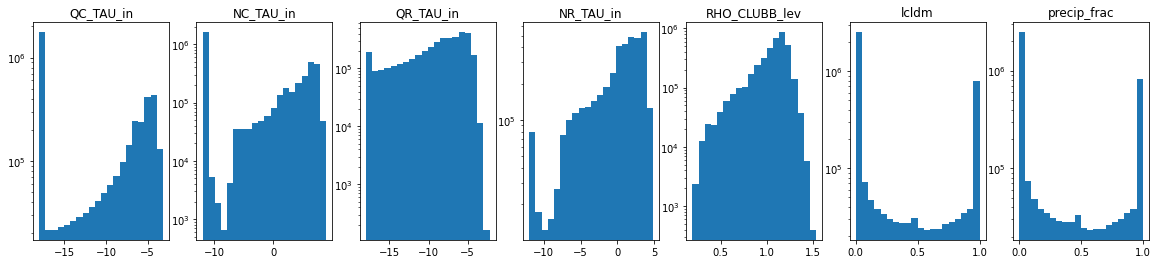

In [9]:
# Histograms of original training input data by column

fig, axes = plt.subplots(1,7, figsize=(20, 4))
transformed_input_train = pd.DataFrame(input_scaler.inverse_transform(scaled_input_train), columns=input_cols)
for a, ax in enumerate(axes.ravel()):
    if a < len(input_cols):
        ax.set_yscale("log")
        ax.hist(transformed_input_train[input_cols[a]], bins=20)
        ax.set_title(input_cols[a])
        

We can reconstruct the model grid for individual timesteps and see the spatial structure in the data.

[33.333333333333336, 66.66666666666667, 100.0, 133.33333333333334, 200.0, 233.33333333333331, 266.6666666666667, 300.0]
[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


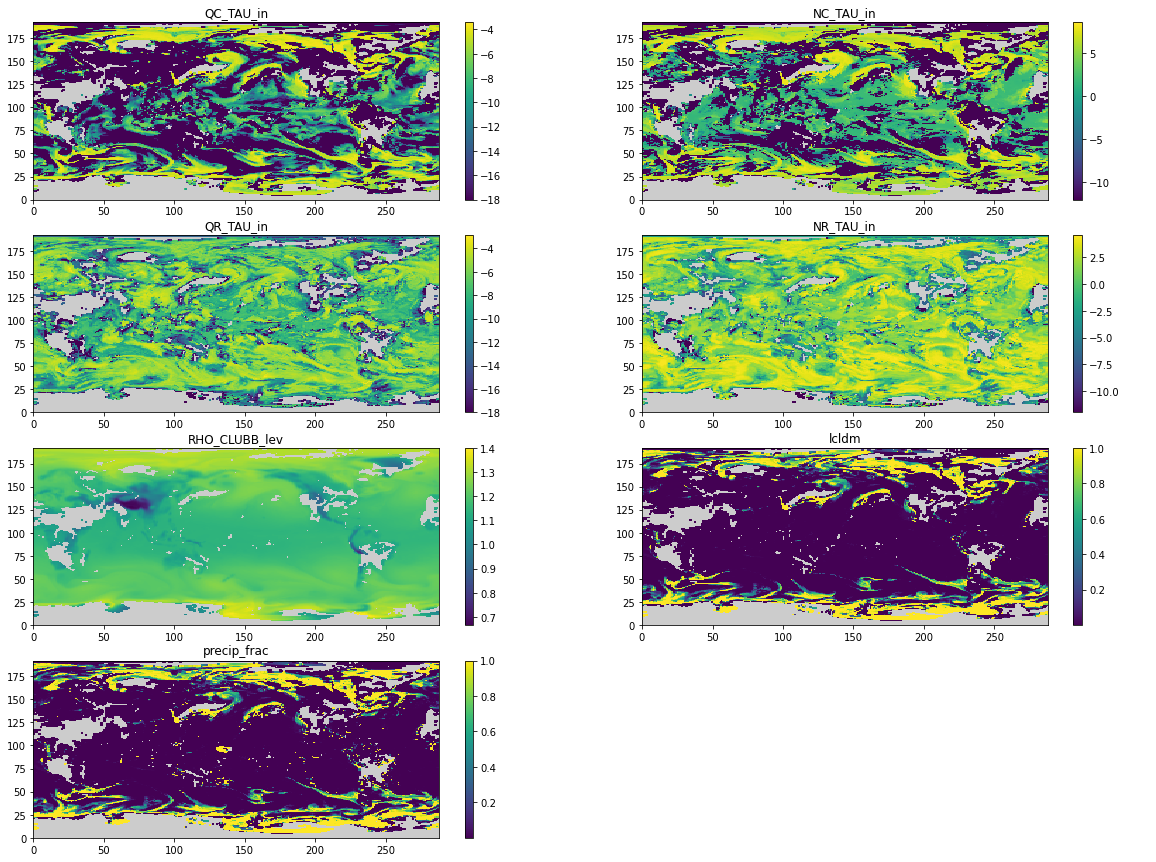

In [10]:
times = sorted(meta_train["time"].unique())
print(times)
depths = sorted(meta_train["depth"].unique())
print(depths)
idx = (meta_train["time"] == times[3]) & (meta_train["depth"] == depths[-3]) 

fig, axes = plt.subplots(4, 2, figsize=(20, 15))
for a, ax in enumerate(axes.ravel()):
    if a < len(input_cols):
        grid_slice = np.ones(grid_shape[1:], dtype=np.float64) * np.nan
        grid_slice[meta_train.loc[idx, "row"], meta_train.loc[idx, "col"]] = transformed_input_train.loc[idx, input_cols[a]]
        pc = ax.pcolormesh(grid_slice, cmap="viridis")
        plt.colorbar(pc, ax=ax)
        ax.set_title(input_cols[a])
        ax.set_facecolor("0.8")

    else:
        ax.axis('off')

[33.333333333333336, 66.66666666666667, 100.0, 133.33333333333334, 200.0, 233.33333333333331, 266.6666666666667, 300.0]
[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


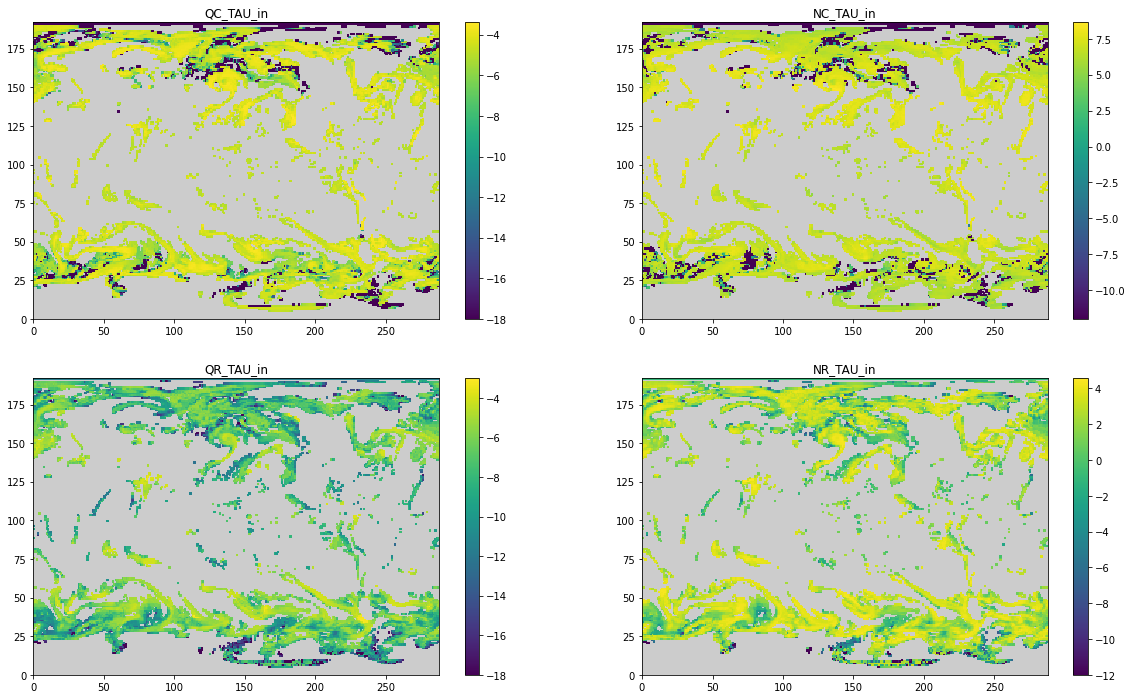

In [11]:
times = sorted(meta_train["time"].unique())
print(times)
depths = sorted(meta_train["depth"].unique())
print(depths)
idx = (meta_train["time"] == times[3]) & (meta_train["depth"] == depths[-5]) & (transformed_input_train["lcldm"] > 0.1) 

fig, axes = plt.subplots(2, 2, figsize=(20, 12))
for a, ax in enumerate(axes.ravel()):
    if a < len(input_cols):
        grid_slice = np.ones(grid_shape[1:], dtype=np.float64) * np.nan
        grid_slice[meta_train.loc[idx, "row"], meta_train.loc[idx, "col"]] = transformed_input_train.loc[idx, input_cols[a]]
        pc = ax.pcolormesh(grid_slice, cmap="viridis")
        plt.colorbar(pc, ax=ax)
        ax.set_title(input_cols[a])
        ax.set_facecolor("0.8")
    else:
        ax.axis('off')

In [12]:
# load and view a single file

fs = s3fs.S3FileSystem(anon=True)
filenames = fs.ls("s3://ncar-aiml-data-commons/microphysics")
fobj = fs.open(filenames[0])
single_file = pd.read_parquet(fobj).set_index('Index')
single_file.head()


,lat,lev,lon,P0,PS,depth,row,col,hyam,hybm,...,precip_frac,qctend_MG2,qctend_TAU,nctend_MG2,nctend_TAU,qrtend_MG2,qrtend_TAU,nrtend_MG2,nrtend_TAU,time
Index,,,,,,,,,,,,,,,,,,,,,
0,-88.115183,957.48548,28.75,100000.0,68814.664,29,2,23,0.006255,0.951231,...,0.5,-1.315998e-15,-2.864113e-25,-0.012213,-0.000461,1.315998e-15,0.0,0.000020,0.0,0.0
1,-88.115183,957.48548,30.00,100000.0,68741.100,29,2,24,0.006255,0.951231,...,0.5,-2.648823e-14,-5.759241e-25,-0.072859,-0.026884,2.648823e-14,0.0,0.000405,0.0,0.0
2,-88.115183,957.48548,31.25,100000.0,68667.195,29,2,25,0.006255,0.951231,...,1.0,-3.268663e-14,3.867864e-25,-0.108811,-0.059724,3.268663e-14,0.0,0.000499,0.0,0.0
3,-88.115183,957.48548,32.50,100000.0,68593.090,29,2,26,0.006255,0.951231,...,1.0,-8.188127e-14,-2.839463e-24,-0.187248,-0.176943,8.188127e-14,0.0,0.001251,0.0,0.0
4,-88.115183,957.48548,33.75,100000.0,68518.980,29,2,27,0.006255,0.951231,...,1.0,-1.991433e-13,2.097941e-24,-0.301633,-0.443875,1.991433e-13,0.0,0.003043,0.0,0.0


## Baseline Machine Learning Model


A baseline model for solving this problem uses an in-series classifier to regressor neural network architecture implemented in Keras.  Initially, there are three classifier networks that feed into four regressor networks. Each classifier and regressor network has 4 hidden layers of 30 neurons each and relu activation. Those hidden layers then feed into a final output layer of size 2 or 3 for classification (1 and 0 or 1, 0, and -1) and of size 1 for regression. The classifier models are trained using the categorial crosstenropy loss function while the regression models are trained using the mean squared error loss function.

<center><img src='micro_images/mlmicrophysics_nn.png'><center>


In [20]:
from tensorflow.keras.layers import Input, Dense, Dropout, GaussianNoise, Activation, Concatenate, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow.keras.backend as K
import xarray as xr
class DenseNeuralNetwork(object):
    """
    A Dense Neural Network Model that can support arbitrary numbers of hidden layers.

    Attributes:
        hidden_layers: Number of hidden layers
        hidden_neurons: Number of neurons in each hidden layer
        inputs: Number of input values
        outputs: Number of output values
        activation: Type of activation function
        output_activation: Activation function applied to the output layer
        optimizer: Name of optimizer or optimizer object.
        loss: Name of loss function or loss object
        use_noise: Whether or not additive Gaussian noise layers are included in the network
        noise_sd: The standard deviation of the Gaussian noise layers
        use_dropout: Whether or not Dropout layers are added to the network
        dropout_alpha: proportion of neurons randomly set to 0.
        batch_size: Number of examples per batch
        epochs: Number of epochs to train
        verbose: Level of detail to provide during training
        model: Keras Model object
    """
    def __init__(self, hidden_layers=1, hidden_neurons=4, activation="relu",
                 output_activation="linear", optimizer="adam", loss="mse", use_noise=False, noise_sd=0.01,
                 lr=0.001, use_dropout=False, dropout_alpha=0.1, batch_size=128, epochs=2,
                 l2_weight=0.01, sgd_momentum=0.9, adam_beta_1=0.9, adam_beta_2=0.999, decay=0, verbose=0,
                 classifier=False):
        self.hidden_layers = hidden_layers
        self.hidden_neurons = hidden_neurons
        self.activation = activation
        self.output_activation = output_activation
        self.optimizer = optimizer
        self.optimizer_obj = None
        self.sgd_momentum = sgd_momentum
        self.adam_beta_1 = adam_beta_1
        self.adam_beta_2 = adam_beta_2
        self.loss = loss
        self.lr = lr
        self.l2_weight = l2_weight
        self.batch_size = batch_size
        self.use_noise = use_noise
        self.noise_sd = noise_sd
        self.use_dropout = use_dropout
        self.dropout_alpha = dropout_alpha
        self.epochs = epochs
        self.decay = decay
        self.verbose = verbose
        self.classifier = classifier
        self.y_labels = None
        self.y_labels_val = None
        self.model = None
        self.optimizer_obj = None

    def build_neural_network(self, inputs, outputs):
        """
        Create Keras neural network model and compile it.

        Args:
            inputs (int): Number of input predictor variables
            outputs (int): Number of output predictor variables
        """
        nn_input = Input(shape=(inputs,), name="input")
        nn_model = nn_input
        for h in range(self.hidden_layers):
            nn_model = Dense(self.hidden_neurons, activation=self.activation,
                             kernel_regularizer=l2(self.l2_weight), name=f"dense_{h:02d}")(nn_model)
            if self.use_dropout:
                nn_model = Dropout(self.dropout_alpha, name=f"dropout_h_{h:02d}")(nn_model)
            if self.use_noise:
                nn_model = GaussianNoise(self.noise_sd, name=f"ganoise_h_{h:02d}")(nn_model)
        nn_model = Dense(outputs,
                         activation=self.output_activation, name=f"dense_{self.hidden_layers:02d}")(nn_model)
        self.model = Model(nn_input, nn_model)
        if self.optimizer == "adam":
            self.optimizer_obj = Adam(lr=self.lr, beta_1=self.adam_beta_1, beta_2=self.adam_beta_2, decay=self.decay)
        elif self.optimizer == "sgd":
            self.optimizer_obj = SGD(lr=self.lr, momentum=self.sgd_momentum, decay=self.decay)
        self.model.compile(optimizer=self.optimizer, loss=self.loss)

    def fit(self, x, y, xv, yv):
        inputs = x.shape[1]
        if len(y.shape) == 1:
            outputs = 1
        else:
            outputs = y.shape[1]
        if self.classifier:
            outputs = np.unique(y).size
        self.build_neural_network(inputs, outputs)
        self.model.summary()
        if self.classifier:
            self.y_labels = np.unique(y)
            self.y_labels_val = np.unique(yv)
            y_class = np.zeros((y.shape[0], self.y_labels.size), dtype=np.int32)
            y_class_val = np.zeros((yv.shape[0], self.y_labels_val.size), dtype=np.int32)
            for l, label in enumerate(self.y_labels):
                y_class[y == label, l] = 1
            for l, label in enumerate(self.y_labels_val):
                y_class_val[yv == label, l] = 1
            self.model.fit(x, y_class, batch_size=self.batch_size,
                           epochs=self.epochs, verbose=self.verbose,
                           validation_data=(xv, y_class_val))
        else:
            self.model.fit(x, y, batch_size=self.batch_size, epochs=self.epochs,
                           verbose=self.verbose, validation_data=(xv, yv))
        return self.model.history.history

    def save_fortran_model(self, filename):
        nn_ds = xr.Dataset()
        num_dense = 0
        layer_names = []
        for layer in self.model.layers:
            if "dense" in layer.name:
                layer_names.append(layer.name)
                dense_weights = layer.get_weights()
                nn_ds[layer.name + "_weights"] = ((layer.name + "_in", layer.name + "_out"), dense_weights[0])
                nn_ds[layer.name + "_bias"] = ((layer.name + "_out",), dense_weights[1])
                nn_ds[layer.name + "_weights"].attrs["name"] = layer.name
                nn_ds[layer.name + "_weights"].attrs["activation"] = layer.get_config()["activation"]
                num_dense += 1
        nn_ds["layer_names"] = (("num_layers",), np.array(layer_names))
        nn_ds.attrs["num_layers"] = num_dense
        nn_ds.to_netcdf(filename, encoding={'layer_names':{'dtype': 'S1'}})
        return

    def predict(self, x, batch_size=None):
        if batch_size is None:
            batch_size = self.batch_size
        if self.classifier:
            y_prob = self.model.predict(x, batch_size=batch_size)
            y_out = self.y_labels[np.argmax(y_prob, axis=1)].ravel()
        else:
            y_out = self.model.predict(x, batch_size=batch_size).ravel()
        return y_out

    def predict_proba(self, x, batch_size=None):
        if batch_size is None:
            batch_size = self.batch_size
        y_prob = self.model.predict(x, batch_size=batch_size)
        return y_prob

In [18]:
# define model hyper parameters

classifier_metrics = ["acc", "pss", "hss", "precision", "recall"]
regressor_metrics = ["rmse", "mae", "r2", "hellinger"]

classifier_networks = {"hidden_layers" : 3,
                       "hidden_neurons" : 30,
                       "loss" : "categorical_crossentropy",
                       "output_activation" : "softmax",
                       "activation" : "relu",
                       "epochs" : 10,
                       "batch_size" : 1024,
                       "verbose" : 1,
                       "lr" : 0.0001,
                       "l2_weight" : 1.0e-5,
                       "classifier" : 1}

regressor_networks = {"hidden_layers" : 3,
                      "hidden_neurons" : 30,
                      "loss" : "mse",
                      "output_activation" : "linear",
                      "activation" : "relu",
                      "epochs" : 10,
                      "batch_size" : 1024,
                      "verbose" : 1,
                      "lr" : 0.0001,
                      "l2_weight" : 1.0e-5,
                      "classifier" : 0}

# hyperparameter dictionaries
class_metrics = {"accuracy": accuracy_score,
                 "heidke": heidke_skill_score,
                 "peirce": peirce_skill_score,
                 "precision": precision_score,
                 "recall": recall_score}

reg_metrics = {"rmse": root_mean_squared_error,
               "mae": mean_absolute_error,
               "r2": r2_corr,
               "hellinger": hellinger_distance}


In [21]:
# build and fit the model

histories = {"classifiers": {}, "regressors": {}}
classifiers = dict()
regressors = dict()
reg_index = []
for output_col in output_cols:
    for label in list(output_transforms[output_col].keys()):
        if label != 0:
            reg_index.append(output_col + f"_{label:d}")
test_prediction_values = np.zeros((scaled_out_test.shape[0], len(reg_index)))
test_prediction_labels = np.zeros(scaled_out_test.shape)
classifier_scores = pd.DataFrame(0, index=output_cols, columns=["accuracy", "heidke", "peirce", "precision", "recall"])
confusion_matrices = dict()
reg_cols = ["rmse", "mae", "r2", "hellinger"]
reg_scores = pd.DataFrame(0, index=reg_index, columns=reg_cols)
l = 0

for o, output_col in enumerate(output_cols):
    print("Train Classifer ", output_col)
    classifiers[output_col] = DenseNeuralNetwork(**classifier_networks)
    hist = classifiers[output_col].fit(scaled_input_train,
                                       labels_train[output_col],
                                       scaled_input_test,
                                       labels_test[output_col])
    histories["classifiers"][output_col] = hist
    classifiers[output_col].save_fortran_model(join(out_path,
                                                    "dnn_{0}_class_fortran.nc".format(output_col[0:2])))
    classifiers[output_col].model.save(join(out_path,"dnn_{0}_class.h5".format(output_col[0:2])))
    regressors[output_col] = dict()
    histories["regressors"][output_col] = dict()
    print("Evaluate Classifier", output_col)
    test_prediction_labels[:, o] = classifiers[output_col].predict(scaled_input_test)
    confusion_matrices[output_col] = confusion_matrix(labels_test[output_col],
                                                      test_prediction_labels  [:, o])
    for class_score in classifier_scores.columns:
        classifier_scores.loc[output_col, class_score] = class_metrics[class_score](labels_test[output_col],
                                                                                    test_prediction_labels[:, o])
    print(classifier_scores.loc[output_col])
    for label in list(output_transforms[output_col].keys()):
        if label != 0:
            print("Train Regressor ", output_col, label)
            regressors[output_col][label] = DenseNeuralNetwork(**regressor_networks)
            hist = regressors[output_col][label].fit(scaled_input_train.loc[labels_train[output_col] == label],
                                                     scaled_out_train.loc[labels_train[output_col] == label, output_col],
                                                     scaled_input_test.loc[labels_test[output_col] == label],
                                                     scaled_out_test.loc[labels_test[output_col] == label, output_col])
            histories["regressors"][output_col][label] = hist

            if label > 0:
                out_label = "pos"
            else:
                out_label = "neg"
            regressors[output_col][label].save_fortran_model(join(out_path,
                                                                  "dnn_{0}_{1}_fortran.nc".format(output_col[0:2],
                                                                                                  out_label)))
            regressors[output_col][label].model.save(join(out_path,
                                                          "dnn_{0}_{1}.h5".format(output_col[0:2], out_label)))
            print("Test Regressor", output_col, label)
            test_prediction_values[:, l] = output_scalers[output_col][label].inverse_transform(
                regressors[output_col][label].predict(scaled_input_test).reshape(-1, 1)).flatten()
            reg_label = output_col + f"_{label:d}"
            for reg_col in reg_cols:
                reg_scores.loc[reg_label,
                               reg_col] = reg_metrics[reg_col](transformed_out_test.loc[labels_test[output_col] == label,
                                                                                        output_col],
                                                                test_prediction_values[labels_test[output_col] == label, l])
            print(reg_scores.loc[reg_label])
            l += 1
print("Saving data")
classifier_scores.to_csv(join(out_path, "dnn_classifier_scores.csv"), index_label="Output")
reg_scores.to_csv(join(out_path, "dnn_regressor_scores.csv"), index_label="Output")
test_pred_values_df = pd.DataFrame(test_prediction_values, columns=reg_index)
test_pred_labels_df = pd.DataFrame(test_prediction_labels, columns=output_cols)
#test_pred_values_df.to_csv(join(out_path, "test_prediction_values.csv"), index_label="index")
#test_pred_labels_df.to_csv(join(out_path, "test_prediction_labels.csv"), index_label="index")
#labels_test.to_csv(join(out_path, "test_cam_labels.csv"), index_label="index")
#transformed_out_test.to_csv(join(out_path, "test_cam_values.csv"), index_label="index")


Train Classifer  qrtend_TAU
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 7)]               0         
_________________________________________________________________
dense_00 (Dense)             (None, 30)                240       
_________________________________________________________________
dense_01 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_02 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_03 (Dense)             (None, 2)                 62        
Total params: 2,162
Trainable params: 2,162
Non-trainable params: 0
_________________________________________________________________
Train on 3898833 samples, validate on 2412726 samples
Epoch 1/10
3898833/3898833 [=============

# Metrics

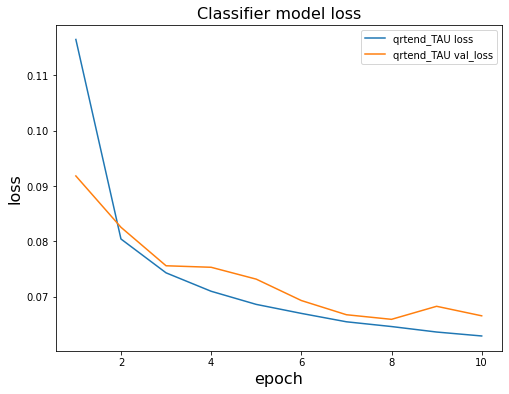

In [22]:
# visualize classifier model performance

plt.figure(figsize=(8,6))

for k in histories['classifiers'].keys():
    plt.plot(np.arange(1, classifier_networks["epochs"]+1), histories['classifiers'][k]['loss'], label=f"{k} loss")
    plt.plot(np.arange(1, classifier_networks["epochs"]+1), histories['classifiers'][k]['val_loss'], label=f"{k} val_loss")
plt.title('Classifier model loss', fontsize=16)
plt.ylabel('loss', fontsize=16)
plt.xlabel('epoch', fontsize=16)
plt.legend(loc='upper right')
plt.show()


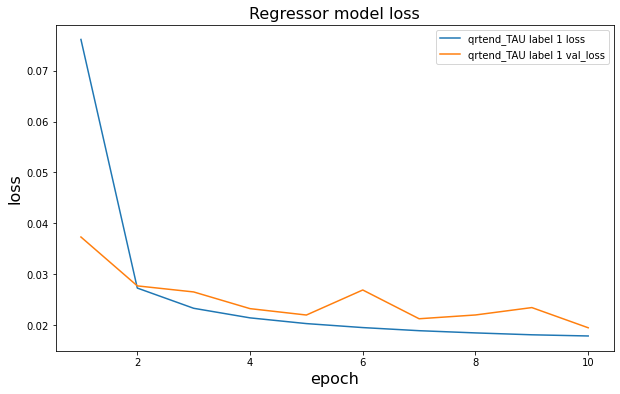

In [23]:
# visualize regressor model performance

plt.figure(figsize=(10,6))
for k in histories['regressors'].keys():
    for l in histories['regressors'][k].keys():
        plt.plot(np.arange(1, classifier_networks["epochs"]+1), histories['regressors'][k][l]['loss'], label=f"{k} label {l} loss")
        plt.plot(np.arange(1, classifier_networks["epochs"]+1), histories['regressors'][k][l]['val_loss'], label=f"{k} label {l} val_loss")
plt.title('Regressor model loss', fontsize=16)
plt.ylabel('loss', fontsize=16)
plt.xlabel('epoch', fontsize=16)
plt.legend(loc='upper right')
plt.show()


In [24]:
cm = confusion_matrices["qrtend_TAU"]
print(cm)
pod = cm[1, 1] / cm[1].sum()
sr = cm[1, 1] / cm[:, 1].sum()
bias = cm[:, 1].sum() / cm[1].sum()  
print(f"Probability of Detection: {pod:0.4f}")
print(f"Success Ratio: {sr:0.4f}")
print(f"Frequency Bias: {bias: 0.3f}")

[[1366897   31878]
 [  33583  980368]]
Probability of Detection: 0.9669
Success Ratio: 0.9685
Frequency Bias:  0.998


Text(0, 0.5, 'Frequency')

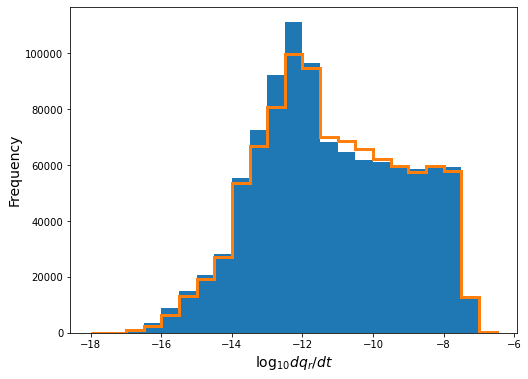

In [26]:
plt.figure(figsize=(8, 6))
bins = np.arange(-18, -6, 0.5)
plt.hist(test_pred_values_df.loc[test_pred_labels_df["qrtend_TAU"] == 1, "qrtend_TAU_1"], bins)
plt.hist(transformed_out_test.loc[test_pred_labels_df["qrtend_TAU"] == 1, "qrtend_TAU"], bins, histtype="step", lw=3)
#plt.gca().set_yscale("log")
plt.xlabel("$\log_{10} dq_r/dt$", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

Text(0, 0.5, 'TAU Bin $\\log_{10} dq_r/dt$')

/glade/u/home/dgagne/miniconda3/envs/goes/lib/python3.7/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


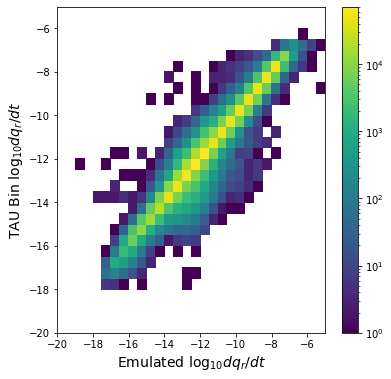

In [27]:
plt.figure(figsize=(6, 6))
_ = plt.hist2d(test_pred_values_df.loc[labels_test["qrtend_TAU"] == 1, "qrtend_TAU_1"], 
           transformed_out_test.loc[labels_test["qrtend_TAU"] == 1, "qrtend_TAU"], 
           bins=np.arange(-20, -4.5, 0.5), cmin=1, norm=LogNorm())
plt.colorbar()
plt.xlabel("Emulated $\log_{10} dq_r/dt$", fontsize=14)
plt.ylabel("TAU Bin $\log_{10} dq_r/dt$", fontsize=14)

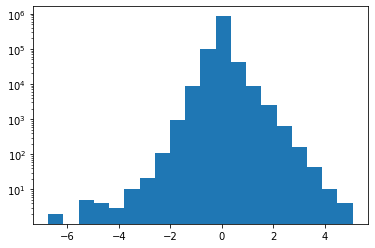

In [30]:
plt.hist(test_pred_values_df.loc[labels_test["qrtend_TAU"] == 1, "qrtend_TAU_1"] - transformed_out_test.loc[labels_test["qrtend_TAU"] == 1, "qrtend_TAU"], bins=20)
plt.gca().set_yscale("log")

In [28]:
out_label

'pos'

## Interpretation
In addition to producing an accurate machine learning model, we want to assess the sensitivity of the machine learning model to the different inputs. We first assess the relative importance of each input followed by how changing each input affects the average prediction.

## Permutation Feature Importance
<center><img src='micro_images/SinglePassPermutation_supplemental_figure4.gif'></center>

Figure from [McGovern et al. 2020](https://journals.ametsoc.org/bams/article/100/11/2175/343787). 

Permutation feature importance is a way to assess the relative contributions of different inputs to predictive skill on average. 

In [31]:
from sklearn.inspection import permutation_importance, partial_dependence
from sklearn.metrics import SCORERS

In [32]:
importance = permutation_importance(classifiers["qrtend_TAU"], scaled_input_train, labels_train["qrtend_TAU"].values, scoring="accuracy", n_jobs=1, n_repeats=1)

Text(0.5, 0, 'Decrease in Accuracy')

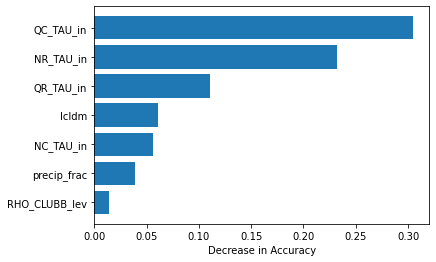

In [33]:
imp = importance['importances'].ravel()
imp_order = imp.argsort()
plt.barh(np.arange(imp.size), imp[imp_order])
plt.yticks(np.arange(imp.size), scaled_input_train.columns.values[imp_order])
plt.xlabel("Decrease in Accuracy")

In [244]:
regressors

{'qrtend_TAU': {1: <mlmicrophysics.models.DenseNeuralNetwork at 0x2b185a0853d0>}}

In [34]:
importance_reg = permutation_importance(regressors["qrtend_TAU"][1], scaled_input_train.loc[labels_train["qrtend_TAU"] == 1], 
                                    scaled_out_train.loc[labels_train["qrtend_TAU"] == 1, "qrtend_TAU"], scoring='neg_mean_squared_error', n_jobs=1, n_repeats=1)

Text(0.5, 0, 'Decrease in Mean Squared Error')

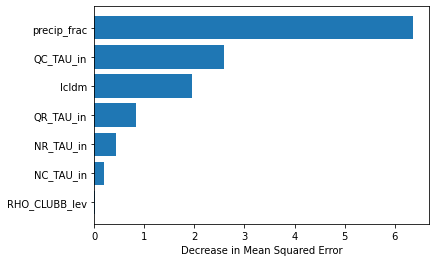

In [35]:
imp = importance_reg['importances'].ravel()
imp_order = imp.argsort()
plt.barh(np.arange(imp.size), imp[imp_order])
plt.yticks(np.arange(imp.size), scaled_input_train.columns.values[imp_order])
plt.xlabel("Decrease in Mean Squared Error")

In [252]:
regressors["qrtend_TAU"][1]

## Partial Dependence Plots

Partial dependence plots are a way to assess the sensitivity of the average prediction from a machine learning model to changes in a single input variable.

In [36]:
def partial_dependence_mp(model, x, var_index, var_values):
    partial_dependence = np.zeros((var_values.shape[1], x.shape[0]), dtype=np.float32)
    x_copy = np.copy(x)
    for v, var_val in enumerate(tqdm(var_values[var_index])):
        x_copy[:, var_index] = var_val
        partial_dependence[v] = model.predict(x_copy).ravel()
    return partial_dependence

In [37]:
pd_eval_points = 30
var_values = np.zeros((scaled_input_train.shape[1], pd_eval_points))
for i in range(scaled_input_train.shape[1]):
    var_values[i] = np.linspace(scaled_input_train.loc[labels_train["qrtend_TAU"] == 1, input_cols[i]].min(), scaled_input_train.loc[labels_train["qrtend_TAU"] == 1, input_cols[i]].max(), pd_eval_points)
var_values_transformed = input_scaler.inverse_transform(var_values.T).T

In [38]:
pd_out = np.zeros((scaled_input_train.columns.size, var_values.shape[1], scaled_input_train.loc[labels_train["qrtend_TAU"] == 1].shape[0]), dtype=np.float32)
for var_index in range(scaled_input_train.columns.size):
    print(var_index)
    pd_out[var_index] = partial_dependence_mp(regressors["qrtend_TAU"][1], scaled_input_train.loc[labels_train["qrtend_TAU"] == 1].values, var_index, var_values)

  0%|          | 0/30 [00:00<?, ?it/s]

0


  0%|          | 0/30 [00:00<?, ?it/s]

1


  0%|          | 0/30 [00:00<?, ?it/s]

2


  0%|          | 0/30 [00:00<?, ?it/s]

3


100%|██████████| 30/30 [00:43<00:00,  1.46s/it]


4


  0%|          | 0/30 [00:00<?, ?it/s]

5


100%|██████████| 30/30 [00:43<00:00,  1.45s/it]


6


100%|██████████| 30/30 [00:40<00:00,  1.36s/it]


In [39]:
def inverse_transform_out(x):
    return x * out_scales_df.values.ravel()[-1] + out_scales_df.values.ravel()[0]

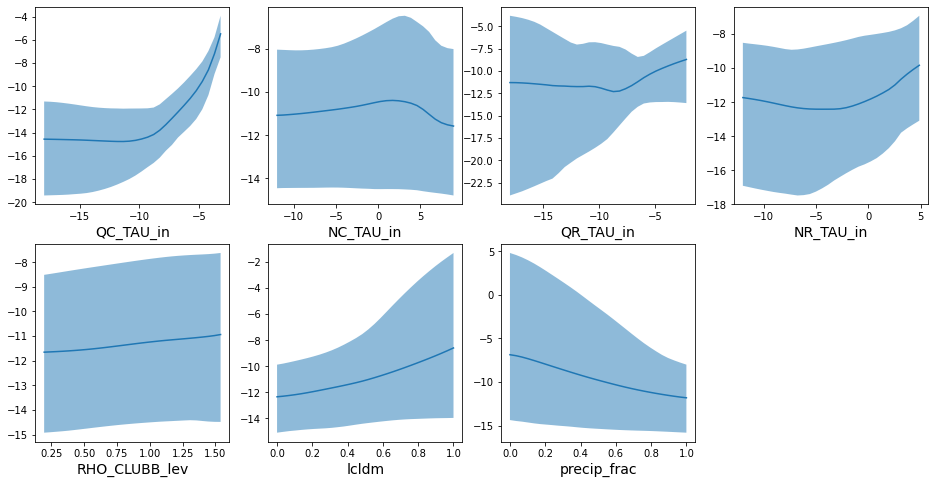

In [40]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for a, ax in enumerate(axes.ravel()):
    if a >= len(input_cols):
        ax.axis("off")
    else:
        ax.fill_between(var_values_transformed[a], inverse_transform_out(np.percentile(pd_out[a], 95, axis=1)), inverse_transform_out(np.percentile(pd_out[a], 5, axis=1)), alpha=0.5)
        ax.plot(var_values_transformed[a], inverse_transform_out(pd_out[a].mean(axis=1)))
        ax.set_xlabel(input_cols[a], fontsize=14)


We will now compare our neural network with the bulk microphysics code from MG2:

\begin{equation}
    \left(\frac{\partial q_r}{\partial t} \right)_{AUTO} = 13.5 q_c^{2.47} N_c^{-1.1}
\end{equation}
\begin{equation}
    \left(\frac{\partial q_r}{\partial t} \right)_{ACCRE} = 67 (q_c q_r)^{1.15}
\end{equation}

In [91]:
class KK2000(object):
    def __init__(self, input_scaler, log_fields):
        self.input_scaler = input_scaler
        self.log_fields = log_fields
        return
    
    def invert_x(self, x):
        x_unscaled = self.input_scaler.inverse_transform(x)
        for l, log_out in enumerate(self.log_fields):
            if log_out == 1:
                x_unscaled[:, l] = 10 ** x_unscaled[:, l]
        return x_unscaled
    
    def predict(self, x):
        x_inverted = self.invert_x(x)
        dqrdt_auto = 13.5 * x_inverted[:, 0] ** 2.47 * x_inverted[:, 1] ** -1.1
        dqrdt_accre = 67 * (x_inverted[:, 0] * x_inverted[:, 2]) ** 1.15
        return dqrdt_auto + dqrdt_accre
        

In [92]:
pd_out_kk = np.zeros((scaled_input_train.columns.size, var_values.shape[1], scaled_input_train.loc[labels_train["qrtend_TAU"] == 1].shape[0]), dtype=np.float32)
kk_mod = KK2000(input_scaler, np.array([1, 1, 1, 1, 0, 0, 0]))
for var_index in range(scaled_input_train.columns.size):
    print(var_index)
    pd_out_kk[var_index] = partial_dependence_mp(kk_mod, scaled_input_train.loc[labels_train["qrtend_TAU"] == 1].values, var_index, var_values)

  0%|          | 0/30 [00:00<?, ?it/s]

0


  0%|          | 0/30 [00:00<?, ?it/s]

1


  0%|          | 0/30 [00:00<?, ?it/s]

2


  0%|          | 0/30 [00:00<?, ?it/s]

3


  0%|          | 0/30 [00:00<?, ?it/s]

4


  0%|          | 0/30 [00:00<?, ?it/s]

5


  0%|          | 0/30 [00:00<?, ?it/s]

6


100%|██████████| 30/30 [00:22<00:00,  1.35it/s]


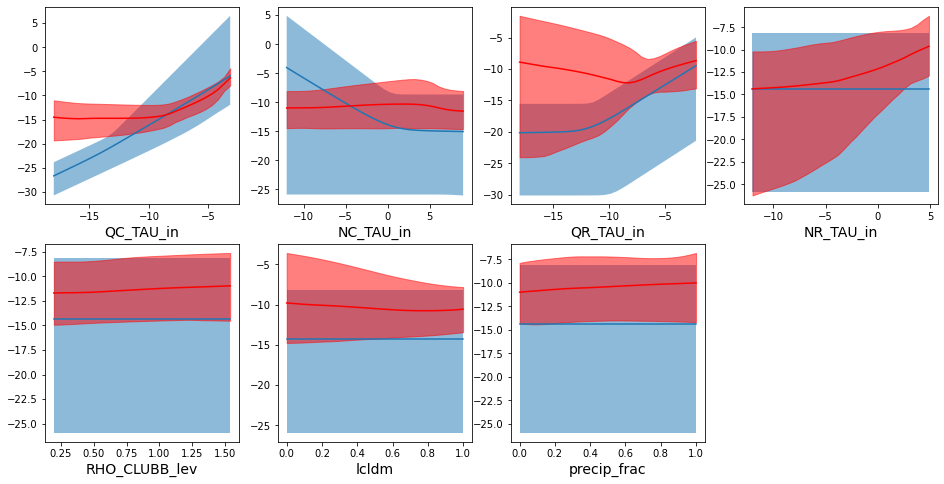

In [103]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for a, ax in enumerate(axes.ravel()):
    if a >= len(input_cols):
        ax.axis("off")
    else:
        ax.fill_between(var_values_transformed[a], 
                        np.percentile(np.log10(pd_out_kk[a]), 95, axis=1), 
                        np.percentile(np.log10(pd_out_kk[a]), 5, axis=1), alpha=0.5)
        ax.plot(var_values_transformed[a], np.log10(pd_out_kk[a]).mean(axis=1))
        ax.fill_between(var_values_transformed[a], inverse_transform_out(np.percentile(pd_out[a], 95, axis=1)), inverse_transform_out(np.percentile(pd_out[a], 5, axis=1)), alpha=0.5, color="r")
        ax.plot(var_values_transformed[a], inverse_transform_out(pd_out[a].mean(axis=1)), color="r")
        ax.set_xlabel(input_cols[a], fontsize=14)

### References


Albrecht, B. A.  (1989).  Aerosols, cloud microphysics and fractional cloudiness. Science, 245, 1227–1230.

Bodas-Salcedo, A., Mulcahy, J. P., Andrews, T., Williams, K. D., Ringer, M. A.,455Field, P. R., & Elsaesser, G. S.(2019). Strong Dependence of Atmospheric Feedbacks on Mixed-Phase Microphysics and Aerosol-Cloud Interactions in HadGEM3. Journal of Advances in Modeling Earth Systems, 11(6), 1735–1758. doi:  10.1029/2019MS001688

Bogenschutz, P. A., Gettelman, A., Morrison, H., Larson, V. E., Craig, C., & Schanen, D. P.(2013).Higher-order turbulence closure and its impact on Climate Simulation in the Community Atmosphere Model.Journal of Climate,26(23), 9655–9676.  doi:  10.1175/JCLI-D-13-00075.1

Danabasoglu, G., Lamarque, J.-F., Bacmeister, J., Bailey, D. A., DuVivier, A. K., Edwards, J., . . .  Strand, W. G.(2020).The Community Earth System Model Version 2 (CESM2).Journal of Advances in Modeling Earth Systems,12(2), e2019MS001916.  doi:  10.1029/2019MS001916

Forbes, R. M., & Ahlgrimm, M.(2014, September).On the Representation of High-Latitude Boundary Layer Mixed-Phase Cloud in the ECMWF Global Model. Monthly Weather Review, 142(9), 3425–3445.  doi:  10.1175/MWR-D-13-00325.1

Gettelman, A.(2015, November).Putting the clouds back in aerosol–cloud interactions. Atmos. Chem. Phys.,15(21), 12397–12411.doi:  10.5194/acp-15-12397-2015

Gettelman, A., Bardeen, C. G., McCluskey, C. S., & Jarvinen, E.    (2020).    Simulating Observations of Southern Ocean Clouds and Implications for Climate.J. Adv. Model. Earth Syst..  doi:  10.1029/2020JD032619

Gettelman, A., Hannay, C., Bacmeister, J. T., Neale, R. B., Pendergrass, A. G., Danabasoglu, G., . . .  Mills, M. J.(2019).High Climate Sensitivity in the Community Earth System Model Version 2 (CESM2).Geophysical Research Letters, 46(14), 8329–8337.  doi:  10.1029/2019GL083978487

Gettelman, A., & Morrison, H.   (2015).   Advanced Two-Moment Bulk Microphysics for Global Models. Part I: Off-Line Tests and Comparison with Other Schemes.J. Climate,28(3), 1268–1287.  doi:  10.1175/JCLI-D-14-00102.1

Gettelman, A., Morrison, H., Santos, S., Bogenschutz, P., & Caldwell, P. M.   (2015). Advanced Two-Moment Bulk Microphysics for Global Models. Part II: Global Model Solutions and Aerosol–Cloud Interactions. J. Climate,28(3), 1288–1307. doi:  10.1175/JCLI-D-14-00103.1

Gettelman, A., & Sherwood, S. C.  (2016, October).  Processes Responsible for Cloud Feedback. Curr Clim Change Rep, 1–11.  doi:  10.1007/s40641-016-0052-8

Golaz, J.-C., Larson, V. E., & Cotton, W. R. (2002). A PDF-Based Model for Boundary Layer Clouds. Part II: Model Results. J. Atmos. Sci.,59, 3552–3571.

Hoose, C., Kristj ́ansson, J. E., Chen, J.-P., & Hazra, A.  (2010, March).  A Classical-Theory-Based Parameterization of Heterogeneous Ice Nucleation by Mineral Dust, Soot, and Biological Particles in a Global Climate Model. J. Atmos. Sci.,67(8), 2483–2503.  doi:  10.1175/2010JAS3425.1

Iacono, M. J., Mlawer, E. J., Clough, S. A., & Morcrette, J.-J.  (2000).  Impact of an improved longwave radiation model, RRTM, on the energy budget and thermodynamic properties of the NCAR community climate model, CCM3.jgr,105(D11),14,873–14,890.

Khairoutdinov, M. F., & Kogan, Y.  (2000).  A new cloud physics parameterization in a large-eddy simulation model of marine stratocumulus. Monthly Weather Review, 128, 229–243.

Larson, V. E., Golaz, J.-C., & Cotton, W. R.(2002, December).Small-Scale and Mesoscale Variability in Cloudy Boundary Layers:  Joint Probability Density Functions.J. Atmos. Sci.,59(24), 3519–3539.   doi:  10.1175/1520-0469(2002)059〈3519:SSAMVI〉2.0.CO;2

Liu, X., & Penner, J. E.  (2005).  Ice Nucleation Parameterization for Global Models. Meteor. Z.,14(499-514).

Michibata, T., & Takemura, T.(2015, September).Evaluation of autoconversion schemes in a single model framework with satellite observations. J. Geophys. Res. Atmos., 120(18), 2015JD023818.  doi:  10.1002/2015JD023818

Neale, R. B., Richter, J. H., & Jochum, M.(2008).The Impact of Convection on ENSO: From a Delayed Oscillator to a Series of Events.J. Climate,21, doi:  10.1175/2008JCLI2244.1

Pruppacher, H. R., & Klett, J. D.   (1997).Microphysics of Clouds and Precipitation526(Second ed.).  Kluwer Academic.

Seifert, A., & Beheng, K. D.  (2001).  A double-moment parameterization for simulat-531ing autoconversion, accretion and selfcollection.Atmos. Res.,59-60, 265–281.

Shi, X., Liu, X., & Zhang, K.  (2015, February).  Effects of pre-existing ice crystals on cirrus clouds and comparison between different ice nucleation parameterizations with the Community Atmosphere Model (CAM5). Atmospheric Chemistry and Physics,15(3), 1503–1520.  doi:  10.5194/acp-15-1503-2015

Twomey, S.  (1977).  The influence of pollution on the shortwave albedo of clouds. J. Atmos. Sci.,34(7), 1149–1152.

Wang, Y., Liu, X., Hoose, C., & Wang, B.(2014, October). Different contact angle distributions for heterogeneous ice nucleation in the Community Atmospheric Model version 5. Atmos. Chem. Phys., 14(19), 10411–10430.doi:55710.5194/acp-14-10411-2014

Zhang, G. J., & McFarlane, N. A.    (1995).    Sensitivity of climate simulations to the parameterization of cumulus convection in the Canadian Climate Center general circulation model. Atmos. Ocean, 33, 407–446.

## AI4ESS Hackathon Challenges (June 22-26, 2020)

### Monday
* Load the data
* Create an exploratory visualization of the data
* Train a linear model
* Train a decision tree ensemble method of your choice

In [ ]:
# Monday's code goes here


### Tuesday
* Train a densely connected neural network
* Experiment with different architectures

In [ ]:
# Tuesday's code goes here


### Wednesday
* Calculate three relevant evaluation metrics for each ML solution and baseline
* Refine machine learning approaches and test additional hyperparameter settings

In [ ]:
# Wednesday's code goes here


### Thursday 
* Evaluate two interpretation methods for your machine learning solution
* Compare interpretation of baseline with your approach
* Submit best results on project to leaderboard
* Prepare 2 Google Slides on team's approach and submit them 

In [ ]:
# Thursday's code goes here


## Ultimate Submission Code
Please insert your full data processing and machine learning pipeline code in the cell below.